In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective
from VariationalBayes.Models.NormalMixture import normal_mixture as mix

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
num_obs = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
#true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)
true_mu = np.array([ np.linspace(-2., 2., k_num), np.linspace(-2., 2., k_num)]).T

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x, true_z, true_z_ind = mix.generate_data(num_obs, true_mu, true_sigma, true_pi)


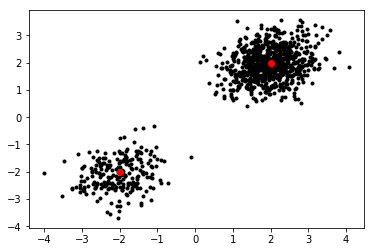

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(num_obs, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.58390281  0.24461066]
 [ 0.69003364  0.21381633]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [6]:

weights = np.full((num_obs, 1), 1.0)
e_z = params['local']['e_z'].get()
get_multinoulli_entropy_hessian = autograd.hessian(mix.multinoulli_entropy)
e_z0 = e_z[0, :]

print(np.max(np.abs(
    get_multinoulli_entropy_hessian(e_z0) - mix.get_sparse_multinoulli_entropy_hessian(e_z0).toarray())))

0.0


In [7]:
model = mix.Model(x, params, prior_params)
model.optimize_z()

kl_obj = SparseObjective(
    model.params, model.kl,
    fun_vector_local_hessian=model.kl_vector_local_hessian_sparse)

kl_obj_dense = Objective(model.params, model.kl)


In [8]:
free_par = params.get_free()
vec_par = params.get_vector()

kl_obj.fun_free(free_par)
grad = kl_obj.fun_free_grad_sparse(free_par)

hvp_time = time.time()
hvp = kl_obj.fun_free_hvp(free_par, grad)
hvp_time = time.time() - hvp_time

global_free_par = params['global'].get_free()
local_free_par = params['local'].get_free()
grad = kl_obj.fun_free_global_grad(global_free_par, local_free_par)
hess = kl_obj.fun_free_global_hessian(global_free_par, local_free_par)

# You can ignore the autograd warning.
sparse_hess_time = time.time()
sparse_hessian = kl_obj.fun_free_hessian_sparse(free_par)
sparse_hess_time = time.time() - sparse_hess_time

print('Sparse Hessian time: \t\t', sparse_hess_time)
print('Hessian vector product time:\t', hvp_time)

if True:
    dense_hess_time = time.time()
    dense_hessian = kl_obj_dense.fun_free_hessian(free_par)
    dense_hess_time = time.time() - dense_hess_time

    print('Dense Hessian time: \t\t', dense_hess_time)
    print('Difference: ', np.max(np.abs(dense_hessian - sparse_hessian)))



/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Sparse Hessian time: 		 0.723060131072998
Hessian vector product time:	 0.01959681510925293
Dense Hessian time: 		 10.142585039138794
Difference:  4.54747350886e-13


In [9]:
# Check the weight Jacobians.
get_loglik_obs_free_local_jac = \
    autograd.jacobian(model.loglik_obs_free_global_local, argnum=1)

free_par_global = model.params['global'].get_free()
free_par_local = model.params['local'].get_free()


loglik_obs_free_local_jac = \
    get_loglik_obs_free_local_jac(free_par_global, free_par_local)

loglik_vector_local_weight_hessian_sparse = \
    model.loglik_vector_local_weight_hessian_sparse()

likelihood_by_obs_free_local_jac_sparse = \
    model.loglik_free_local_weight_hessian_sparse()

print(np.max(np.abs(loglik_obs_free_local_jac - likelihood_by_obs_free_local_jac_sparse)))


4.4408920985e-16


In [10]:
# Perform EM.

model.params.set_free(init_par_vec)
model.optimize_z()
global_param_vec = model.params['global'].get_vector()
kl = model.kl()

for step in range(20):
    global_free_par = model.params['global'].get_free()
    local_free_par = model.params['local'].get_free()
    
    # Different choices for the M step:
    global_vb_opt = optimize.minimize(
       lambda par: kl_obj.fun_free_split(par, local_free_par),
       x0=global_free_par,
       jac=lambda par: kl_obj.fun_free_global_grad(par, local_free_par),
       hess=lambda par: kl_obj.fun_free_global_hessian(par, local_free_par),
       method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
    model.params['global'].set_free(global_vb_opt.x)

    # E-step:
    model.optimize_z()

    new_global_param_vec = model.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = model.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
    if diff < 1e-6:
        break

em_free_par = model.params.get_free()
print('Done.')


 kl: 1253.2913202484253		kl_diff = -2373.193505762565		diff = 1.8035226673510276
 kl: 1248.0997960905627		kl_diff = -5.191524157862659		diff = 0.07496970912639156
 kl: 1231.2685609659866		kl_diff = -16.831235124576096		diff = 0.13566425701164497
 kl: 1168.6183125325597		kl_diff = -62.650248433426896		diff = 0.22858394453304653
 kl: 932.8889542903723		kl_diff = -235.72935824218735		diff = 0.35883946798457994
 kl: 709.0808616319596		kl_diff = -223.80809265841276		diff = 0.9159772039748288
 kl: 671.0927566715418		kl_diff = -37.988104960417786		diff = 0.4858767044324702
 kl: 646.453516373224		kl_diff = -24.63924029831776		diff = 0.34836679138588267
 kl: 608.8062647241428		kl_diff = -37.64725164908123		diff = 0.3216854299626619
 kl: 534.7324620904516		kl_diff = -74.07380263369123		diff = 0.3089846142917425
 kl: 455.91583204604854		kl_diff = -78.81663004440304		diff = 0.7329244458897266
 kl: 453.8669597074019		kl_diff = -2.0488723386466177		diff = 0.22746992316510628
 kl: 453.86695970473295	

In [11]:
# Newton is faster than CG if you go to high-quality optimum.
vb_opt = optimize.minimize(
    kl_obj.fun_free,
    x0=em_free_par,
    jac=kl_obj.fun_free_grad_sparse,
    hess=kl_obj.fun_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('done')
print(kl_obj.fun_free(vb_opt.x))

/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


done
453.866959705


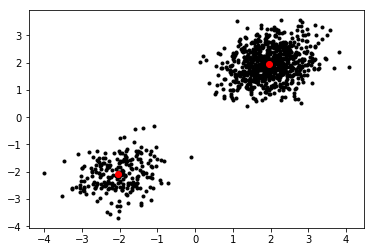

In [12]:
# Check that the solution looks sensible.
mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [13]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

moment_jac = model.get_moment_jacobian(vb_opt.x)

kl_free_hessian_sparse = kl_obj.fun_free_hessian_sparse(vb_opt.x)
sensitivity_operator = \
    sp.sparse.linalg.spsolve(csc_matrix(kl_free_hessian_sparse),
                             csr_matrix(moment_jac).T)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [14]:
weight_jac = model.loglik_free_weight_hessian_sparse()
data_sens = (weight_jac.T * sensitivity_operator).toarray()
print(data_sens.shape)

(1000, 4)


In [16]:
rm_row = 1
keep_rows = np.setdiff1d(np.arange(model.x.shape[0]), rm_row)
model.params.set_free(vb_opt.x)

e_z_rm = vb.SimplexParam(name='e_z', shape=(num_obs - 1, k_num))
e_z_rm.set(model.params['local']['e_z'].get()[keep_rows, :])
rm_local = vb.ModelParamsDict('local')
rm_local.push_param(e_z_rm)

rm_params = vb.ModelParamsDict('mixture model deleted row')
rm_params.push_param(deepcopy(model.params['global']))
rm_params.push_param(rm_local)

rm_model = mix.Model(x[keep_rows, :], rm_params, prior_params)

In [17]:
# rm_model.kl_free(init_par)
# rm_model.kl_free_hessian_sparse(init_par)
rm_kl_obj = SparseObjective(
    rm_model.params, rm_model.kl,
    fun_vector_local_hessian=rm_model.kl_vector_local_hessian_sparse)

init_par = rm_model.params.get_free()
global_vec = rm_model.params['global'].get_vector()
local_vec = rm_model.params['local'].get_vector()

print(rm_model.kl_vector_local_hessian_sparse(global_vec, local_vec))
#print(rm_kl_obj.fun_vector_local_hessian(global_vec, local_vec))

#print(rm_kl_obj.fun_free_hessian_sparse(init_par))
rm_model.optimize_z()

rm_vb_opt = optimize.minimize(
    rm_kl_obj.fun_free,
    x0=init_par,
    jac=rm_kl_obj.fun_free_grad_sparse,
    hess=rm_kl_obj.fun_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('Done')
rm_model.params.set_free(rm_vb_opt.x)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Done


In [ ]:

print('Actual sensitivity:\t', 
      rm_model.get_interesting_moments(rm_vb_opt.x) - model.get_interesting_moments(vb_opt.x))
print('Predicted sensitivity:\t', -1 * data_sens[rm_row, :])
